In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random

In [4]:
def distortedCapture(full_img, x, y, img_size):
#     rotate full image (ra), capture (d, s), flip (flip)
    ra = random.randint(0,359)
    dx = (random.randint(0,10)-5)
    dy = (random.randint(0,10)-5)
    scale = (1.5) - 1
    sx = int(random.randint(0,img_size*scale)-img_size*scale/2)
    sy = int(random.randint(0,img_size*scale)-img_size*scale/2)
    flip = random.randint(0,3)-1
    
    M = cv.getRotationMatrix2D((x,y), ra, 1)
    full_img = cv.warpAffine(full_img, M, (frame.shape[1], frame.shape[0]))
    
    down_b = y-16+dy-sy
    up_b = y+16+dy+sy
    left_b = x-16+dx-sx
    right_b = x+16+dx+sx
    print(down_b,":",up_b ,",", left_b,":",right_b)
    if (down_b < 0 or up_b>full_img.shape[0] or left_b<0 or right_b>full_img.shape[1]):
        return distortedCapture(full_img, x,y,img_size)
    
    ball_img = full_img[y-16+dy-sy : y+16+dy+sy , x-16+dx-sx : x+16+dx+sx]
    ball_img = cv.resize(ball_img, (img_size, img_size))
    
    
    if (flip != 2):
        ball_img = cv.flip(ball_img, flipCode=flip)
    
    
    return ball_img

In [29]:
# LOAD FRAMES
PLACE = "LB"
NUM = 3

csv_name = "ball_pos_data/ball_pos_data_{}_{}.csv".format(PLACE, NUM)
vid_name = "videos/Tennis_{}_{}.mp4".format(PLACE, NUM)

ball_centers = np.loadtxt(csv_name).astype(np.uint32)
cap = cv.VideoCapture(vid_name)

img_size = 32
data_qnty = 300
ball_data = np.zeros((data_qnty,img_size,img_size,3)).astype(np.uint8)


frame # 0
30 : 62 , 1042 : 1080
-4 : 36 , 930 : 954
5 : 25 , 933 : 955
9 : 31 , 1041 : 1083
10 : 42 , 1095 : 1113
3 : 37 , 1504 : 1552
5 : 31 , 1584 : 1630
4 : 38 , 902 : 928
-5 : 33 , 939 : 971
1 : 41 , 942 : 978
11 : 37 , 1231 : 1259
8 : 32 , 1296 : 1344
8 : 24 , 1311 : 1357
13 : 31 , 1525 : 1571
11 : 27 , 789 : 829
10 : 36 , 921 : 965
-6 : 40 , 977 : 1001
10 : 30 , 968 : 1004
9 : 37 , 1093 : 1113
0 : 46 , 1111 : 1141
15 : 37 , 1114 : 1162
-1 : 41 , 1322 : 1362
3 : 47 , 1324 : 1368
27 : 47 , 901 : 917
14 : 34 , 953 : 979
17 : 41 , 1005 : 1045
-3 : 45 , 1597 : 1631
5 : 31 , 1604 : 1640
14 : 50 , 983 : 1005
12 : 54 , 1220 : 1242
10 : 40 , 1062 : 1082
6 : 38 , 1108 : 1138
14 : 32 , 1613 : 1639
10 : 32 , 1616 : 1660
16 : 36 , 1633 : 1653
4 : 42 , 1650 : 1672
9 : 35 , 1655 : 1689
28 : 46 , 472 : 494
14 : 38 , 476 : 496
31 : 51 , 934 : 962
10 : 52 , 942 : 984
17 : 39 , 986 : 1028
12 : 46 , 1131 : 1159
20 : 50 , 899 : 935
21 : 47 , 947 : 981
83 : 101 , 1085 : 1133
6 : 52 , 1117 : 1139
9 : 3

frame # 1


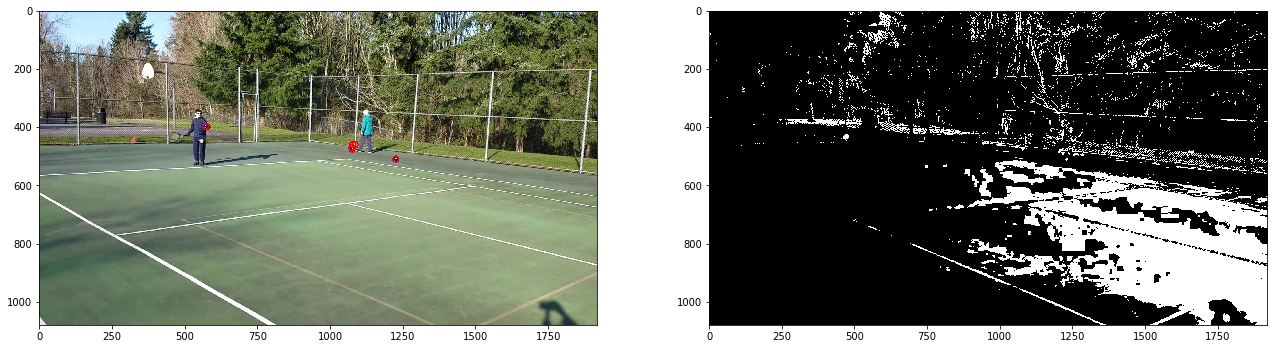

frame # 2


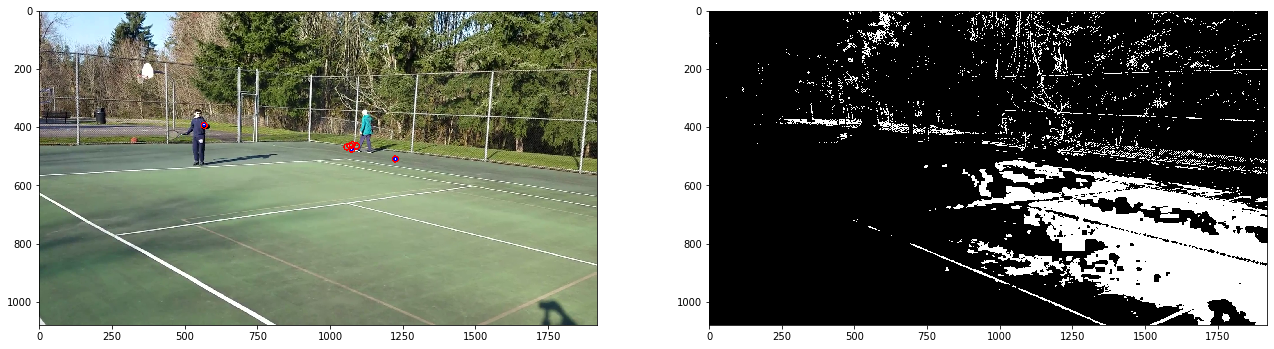

frame # 3


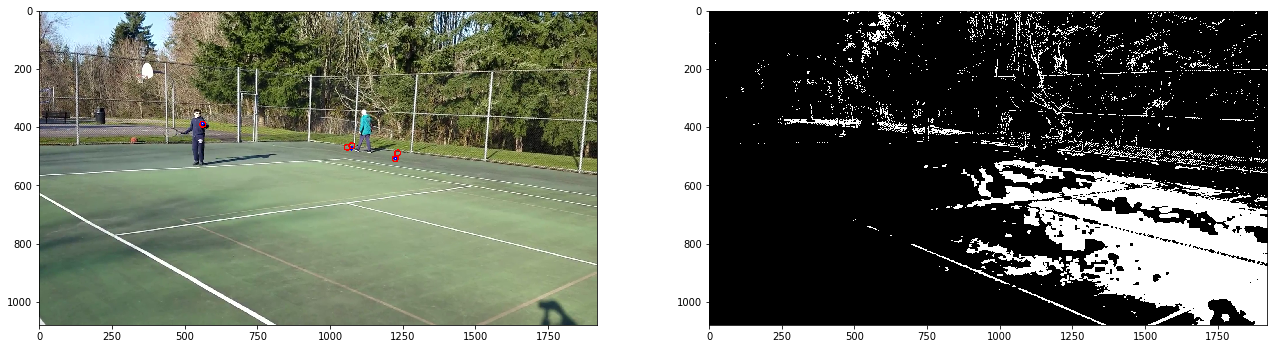

frame # 4


frame # 5


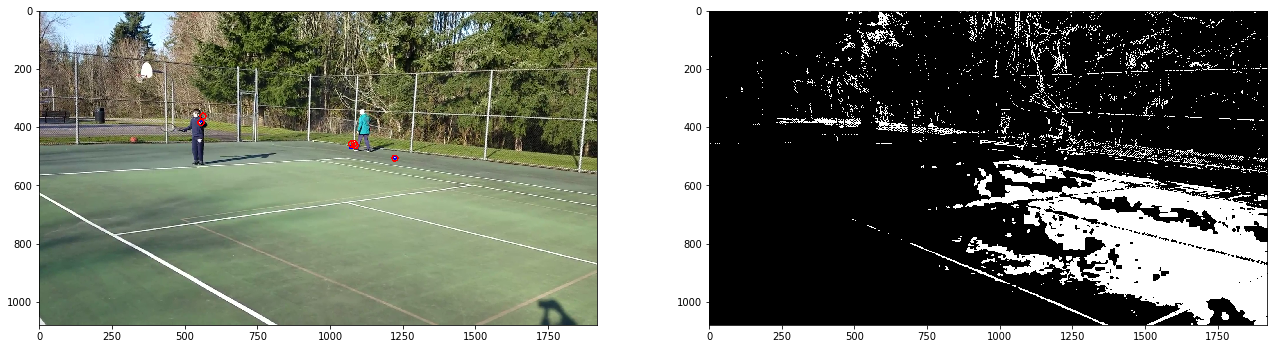

frame # 6


frame # 7


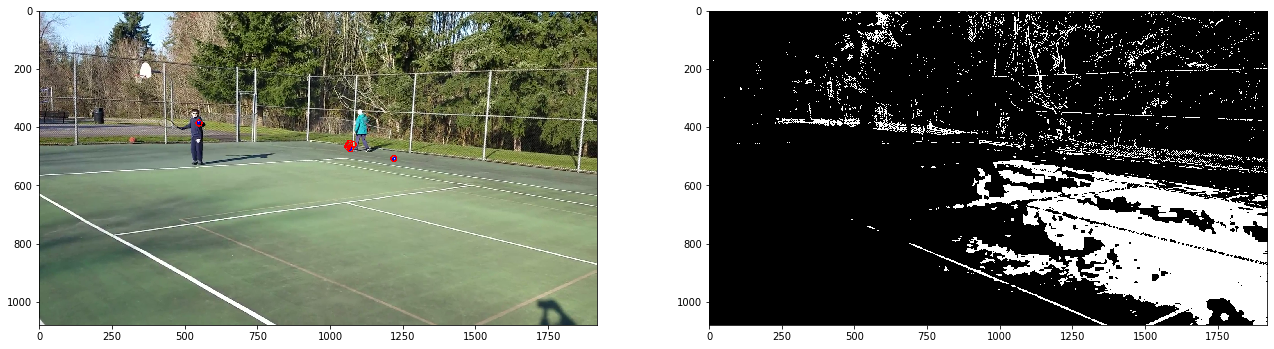

frame # 8


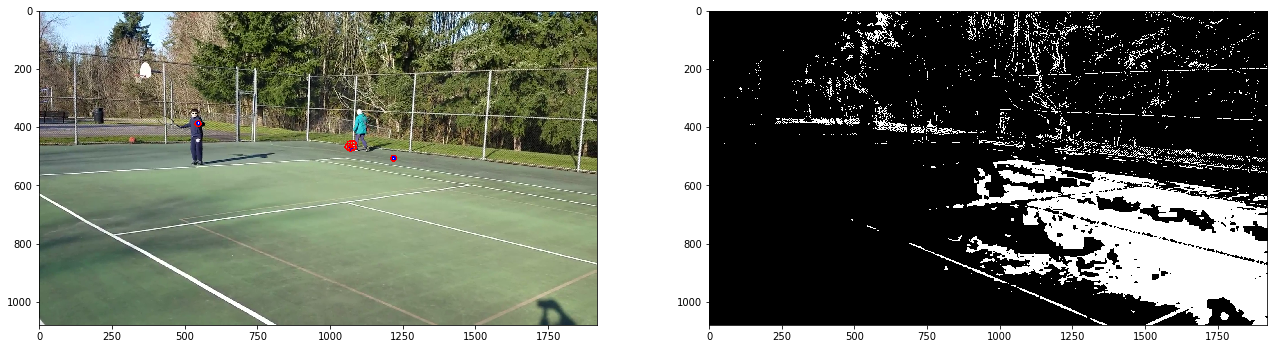

frame # 9


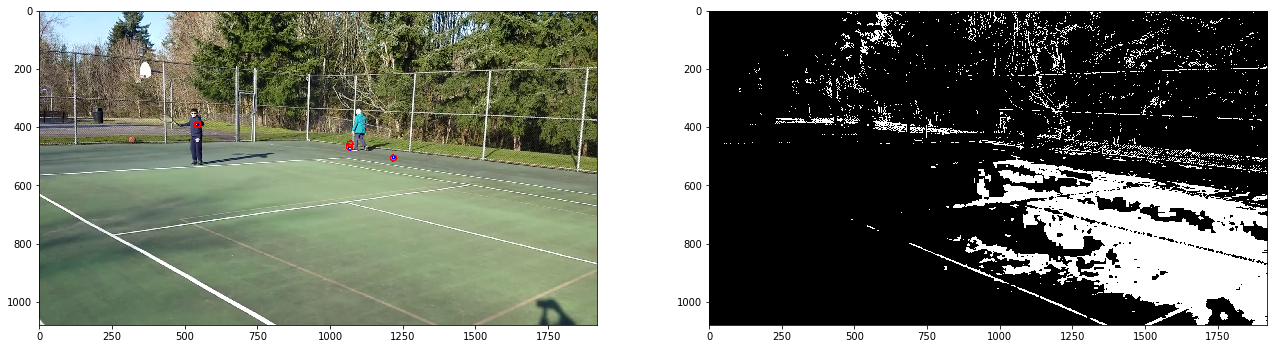

In [30]:
# CAPTURE PICTURES

distort = True

data_count = 0

for i in range(10):
    print("frame #", + i)
    ret, frame = cap.read()
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_thresh = np.zeros((frame_rgb.shape[0],frame_rgb.shape[1]))
    frame_zoomedin = frame_rgb[475:525,475:525,:]

    #print(frame_hsv[475+18:475+22,500:505,:])
    #h: 25-45, s:45-65, v: 250-255
    #https://stackoverflow.com/questions/51229126/how-to-find-the-red-color-regions-using-opencv
    
    #filter based on hsv
    idx_hue_bright = np.logical_and((frame_hsv[:,:,0]>=20), (frame_hsv[:,:,0]<=45))
    idx_sat_bright = np.logical_and((frame_hsv[:,:,1]>=25), (frame_hsv[:,:,1]<=180))
    idx_val_bright = (frame_hsv[:,:,2]>=150)
    idx_hsv_bright = np.logical_and(np.logical_and(idx_hue_bright, idx_sat_bright), idx_val_bright)
    frame_thresh[idx_hsv_bright] = 255

    kernel = np.ones((2,2),np.uint8)
    frame_open = cv.morphologyEx(frame_thresh, cv.MORPH_OPEN, kernel)
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(frame_open.astype(np.uint8) , 8 , cv.CV_32S)
    
    idx_good_size = np.logical_and((stats[:,cv.CC_STAT_AREA]> 10), stats[:,cv.CC_STAT_AREA] <1000)
    centroids_good_size = centroids[idx_good_size]
    
#     print(stats)
    
    cur_ball_centers = ball_centers[(ball_centers[:,0]==i)]
    for ball_center in cur_ball_centers:
         cv.circle(frame_rgb, (int(ball_center[1]), int(ball_center[2])), 5, (0,0,255), 3)
    
    for j in range(centroids_good_size.shape[0]):
        
        distances = cur_ball_centers[:,1:]-centroids_good_size[j].astype(int)
        distances = distances * distances
        distances = distances[:,0] + distances[:,1]
        x = int(centroids_good_size[j,0])
        y = int(centroids_good_size[j,1])
        if (np.min(distances) < 400):
             cv.circle(frame_rgb, (x, y), 10, (255,0,0), 3)
        else: 

            if (data_count<data_qnty and (y in range(16, 1080-16) and (x in range(16, 1920-16)))):
                if distort: 
                    ball_data[data_count] = distortedCapture(frame_rgb, x, y, img_size)
                else:
                    ball_data[data_count] = frame_rgb[y-16:y+16, x-16:x+16]
                data_count +=1
                
#             cv.circle(frame_rgb, (x, y), 10, (0,255,255), 3)

            
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(22,8)
# plt.imshow(frame_open,cmap = "gray")
# plt.figure()
# plt.imshow(frame_zoomedin)
    ax1.imshow(frame_rgb)
    ax2.imshow(frame_open, cmap="gray")
    plt.show()
    
    if (stats.shape[0]==1):
        break

In [31]:
ball_data

array([[[[ 91,  98,  83],
         [ 84,  92,  78],
         [130, 139, 125],
         ...,
         [150, 148, 117],
         [145, 143, 114],
         [176, 174, 145]],

        [[ 63,  71,  54],
         [ 99, 108,  91],
         [151, 162, 145],
         ...,
         [179, 177, 147],
         [174, 172, 143],
         [184, 182, 153]],

        [[ 79,  87,  70],
         [142, 152, 134],
         [156, 168, 150],
         ...,
         [197, 195, 165],
         [169, 167, 138],
         [148, 145, 119]],

        ...,

        [[109, 117,  87],
         [ 80,  88,  54],
         [ 87,  94,  57],
         ...,
         [160, 159, 128],
         [161, 160, 129],
         [150, 150, 118]],

        [[ 79,  86,  54],
         [ 57,  64,  31],
         [ 75,  80,  44],
         ...,
         [118, 117,  85],
         [128, 127,  95],
         [127, 126,  96]],

        [[ 79,  86,  54],
         [ 61,  67,  33],
         [ 82,  87,  51],
         ...,
         [ 94,  93,  61],
        

In [32]:
np.save("nonball_data/ball-_data_{}_{}.npy".format(PLACE, NUM), ball_data)

In [33]:
# COMBINE DATA

import glob
data_files = glob.glob('nonball_data/*.npy')
data_files.remove("nonball_data/ball-_data.npy")

data = np.load(data_files[0])

for i in range(1, len(data_files)):
    data2 = np.load(data_files[i])
    data = np.concatenate((data, data2))
print(data.shape)
np.save("nonball_data/ball-_data.npy", data)

(1200, 32, 32, 3)


/Users/Moishe/anaconda3/envs/cvd/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


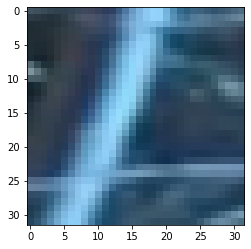

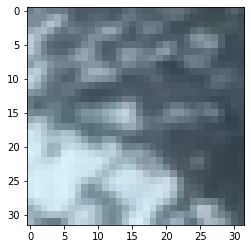

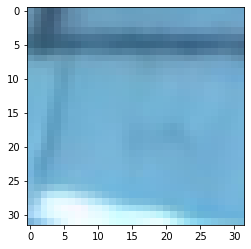

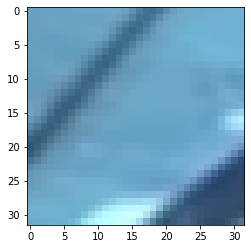

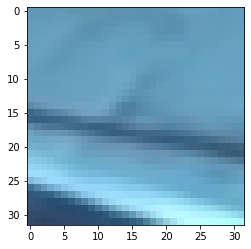

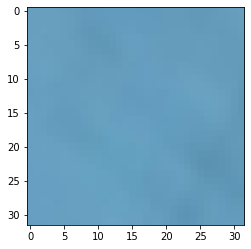

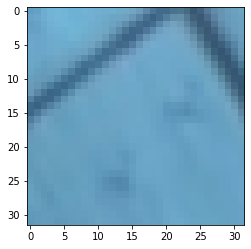

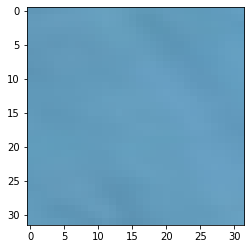

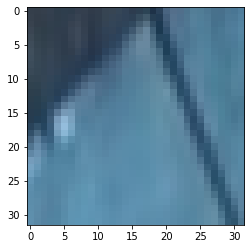

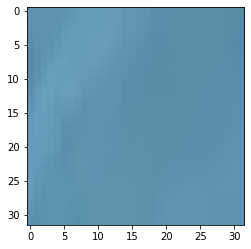

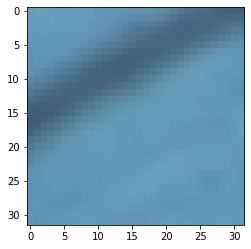

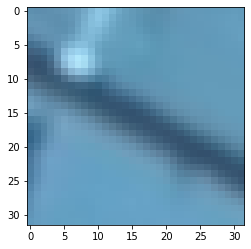

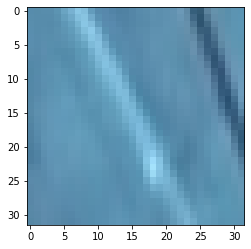

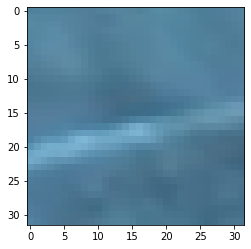

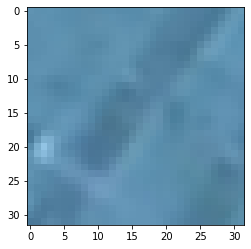

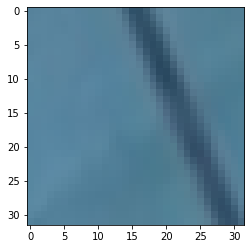

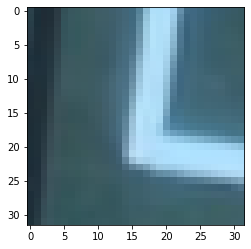

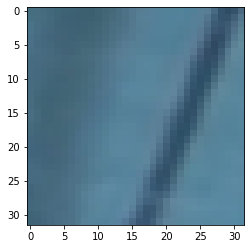

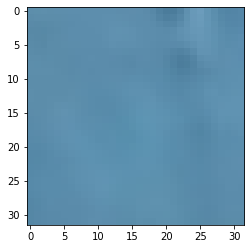

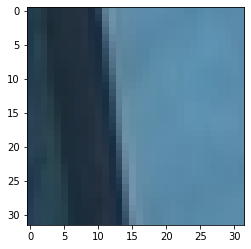

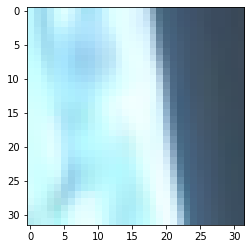

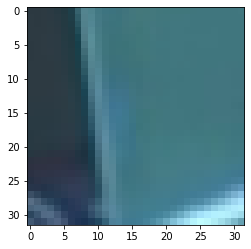

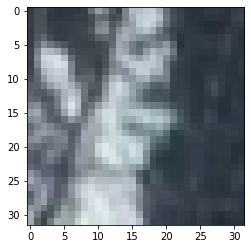

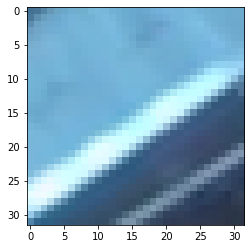

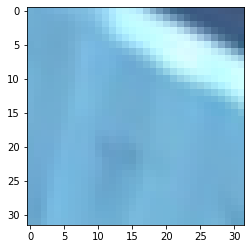

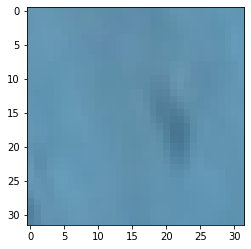

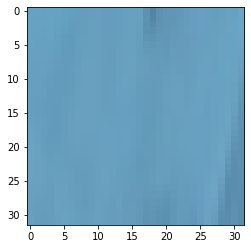

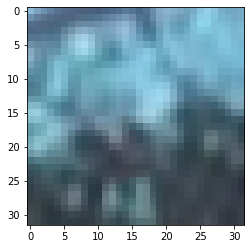

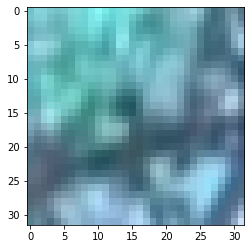

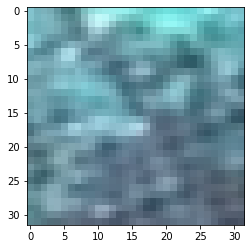

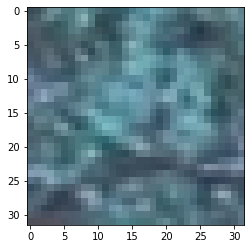

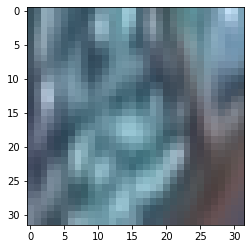

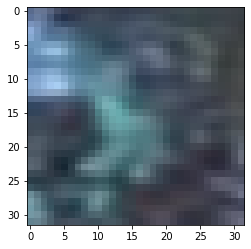

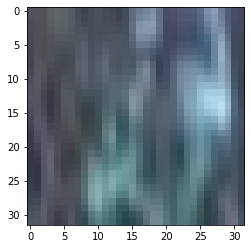

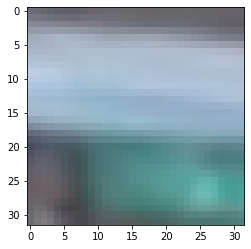

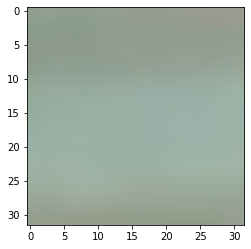

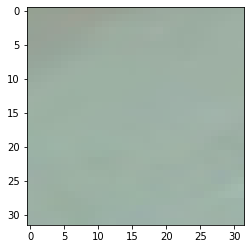

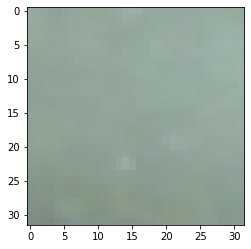

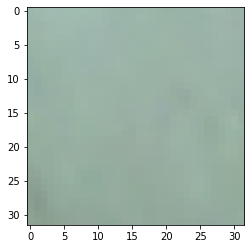

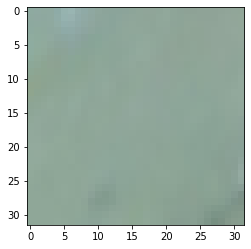

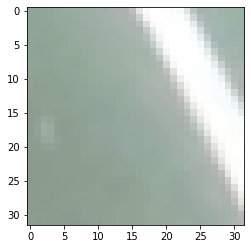

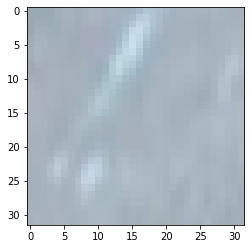

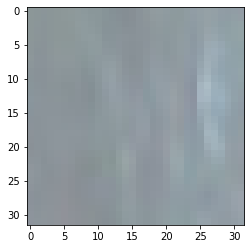

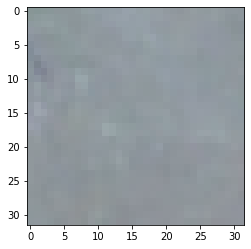

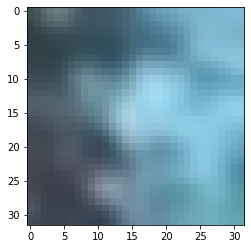

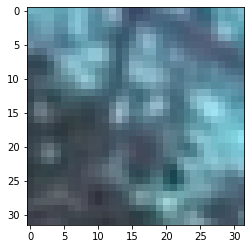

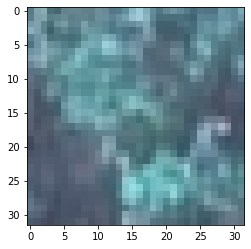

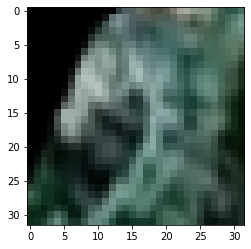

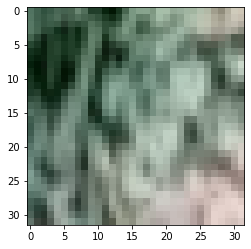

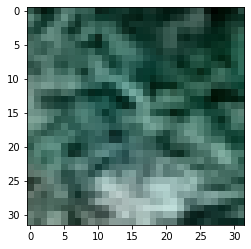

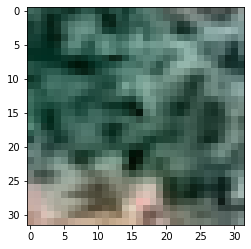

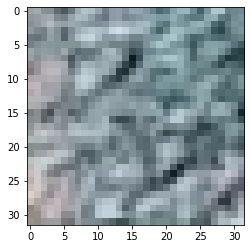

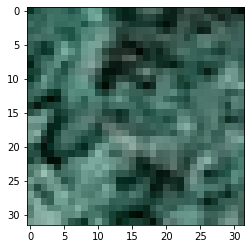

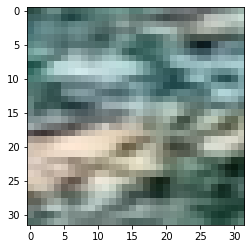

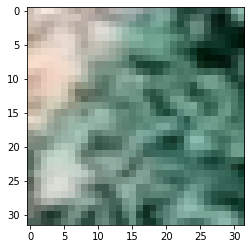

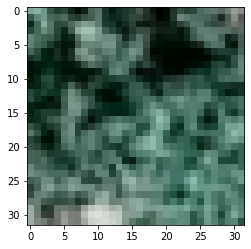

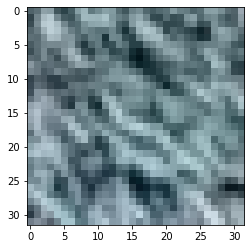

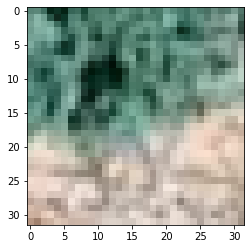

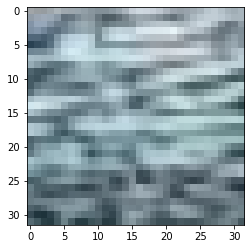

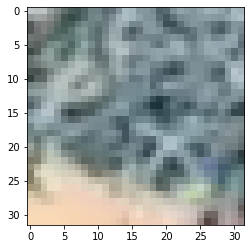

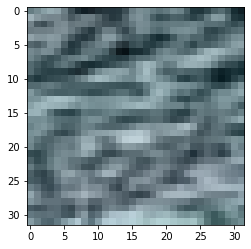

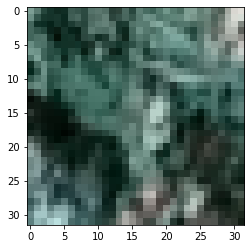

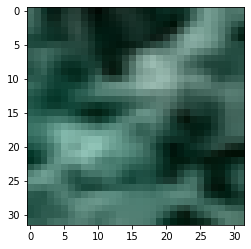

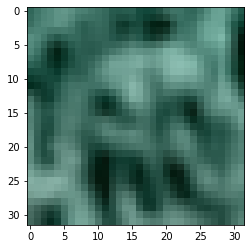

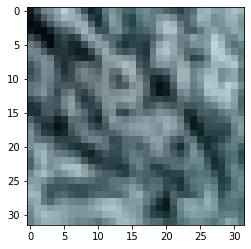

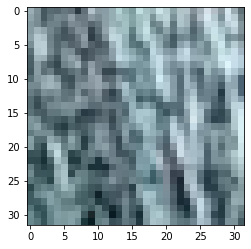

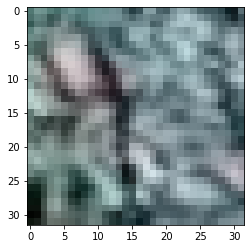

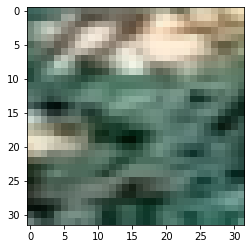

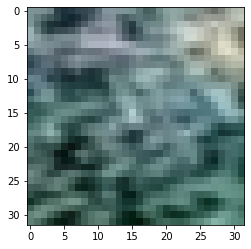

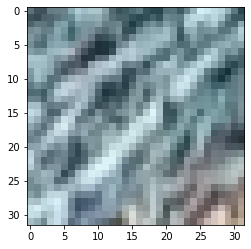

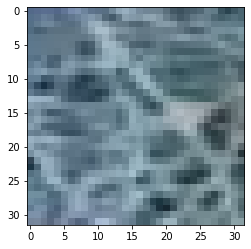

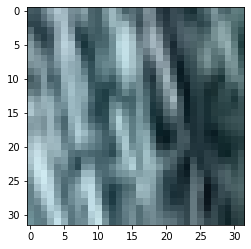

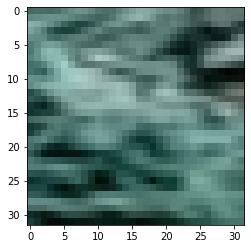

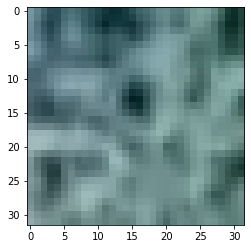

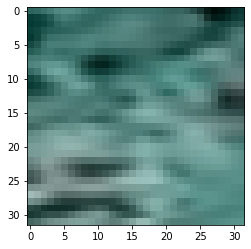

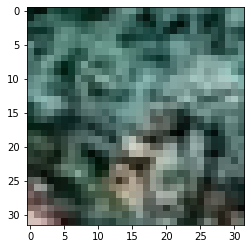

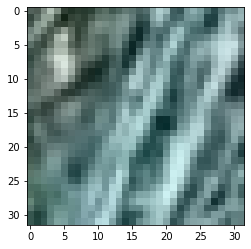

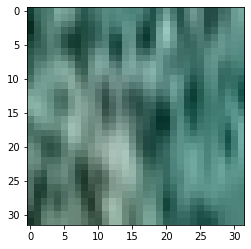

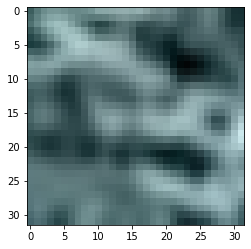

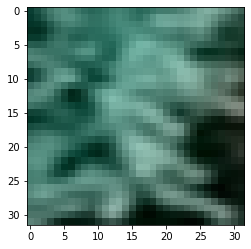

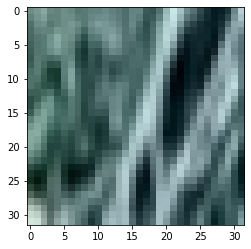

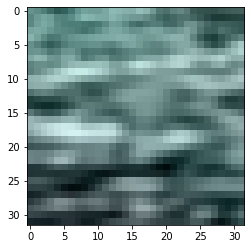

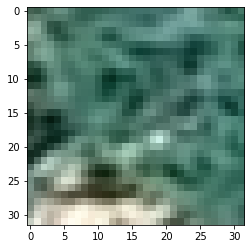

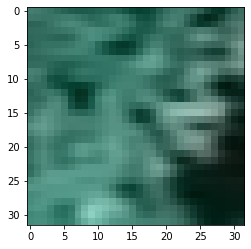

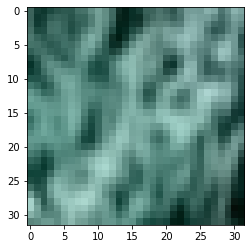

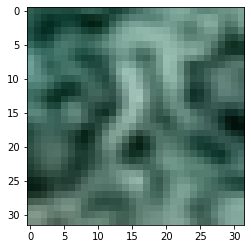

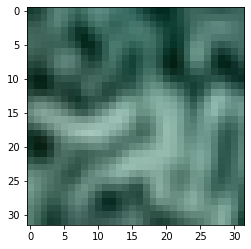

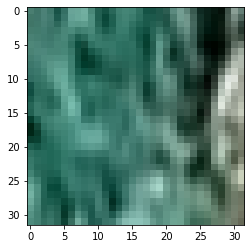

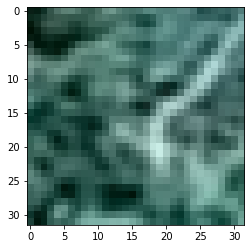

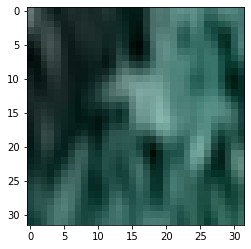

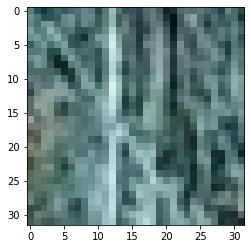

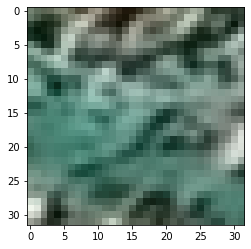

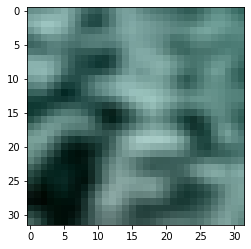

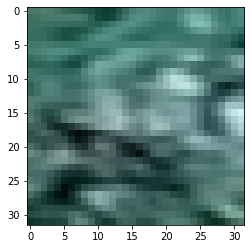

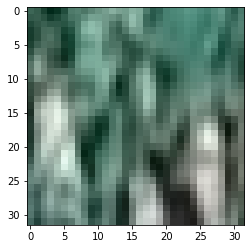

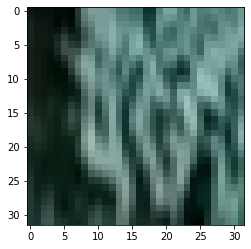

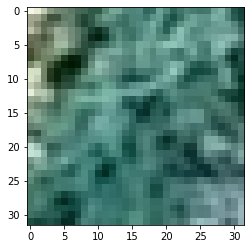

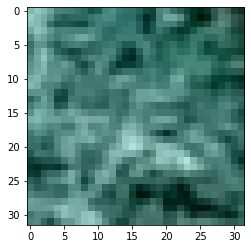

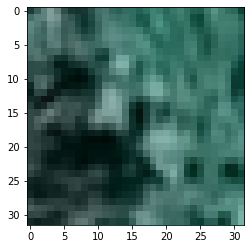

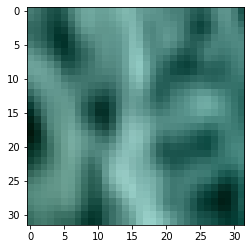

In [34]:
# LOOK THROUGH SAMPLES OF DATA

data = np.load("nonball_data/ball-_data.npy")
for i in range(int(data.shape[0]/10)):
    plt.figure()
    plt.imshow(cv.cvtColor(data[i*10,:,:,:], cv.COLOR_BGR2RGB))